# Ranking Difference Learning Rate

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from htc.fonts.set_font import set_font
from htc.settings import settings
from htc.settings_seg import settings_seg

set_font()

In [2]:
df_fixed = pd.read_pickle(settings.results_dir / "challengeR/lrs/bootstrapped_fixed.pkl.xz")
df_best = pd.read_pickle(settings.results_dir / "challengeR/lrs/bootstrapped_best.pkl.xz")
df_runs_fixed = pd.read_pickle(settings.results_dir / "challengeR/lrs/runs_fixed.pkl.xz")
df_runs_best = pd.read_pickle(settings.results_dir / "challengeR/lrs/runs_best.pkl.xz")
fixed_lr = df_runs_fixed["lr"].unique().item()

assert df_fixed.shape == df_best.shape
assert np.all(df_fixed["rowname"].values == df_best["rowname"].values)
assert np.all(df_fixed["final_rank"].values == df_best["final_rank"].values)

fixed = df_fixed.drop(columns=["rowname", "final_rank"]).values
best = df_best.drop(columns=["rowname", "final_rank"]).values
diff = fixed - best
assert diff.shape[0] == settings_seg.n_algorithms and diff.shape[1] == 1000

In [3]:
# Calculate differences in ranks across bootstraps
diff_range = np.max(diff) - np.min(diff) + 1
diffcounts = np.zeros((diff_range, settings_seg.n_algorithms), dtype=int)
for i in range(settings_seg.n_algorithms):
    for j in range(diff.shape[1]):
        d = 1 - diff[i, j]
        diffcounts[d, i] += 1

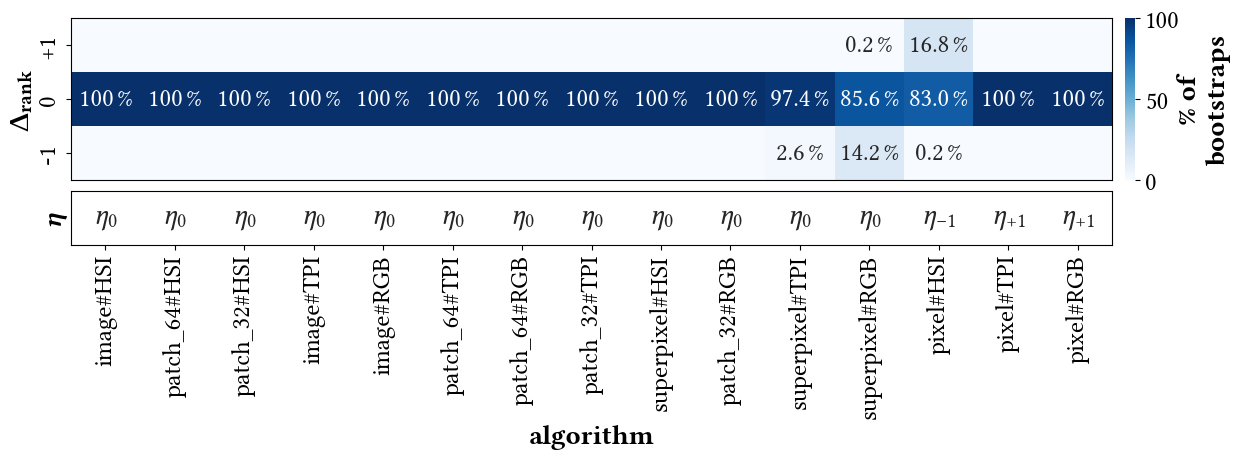

In [4]:
# confusion matrix with relative numbers
fig, (ax1, ax2) = plt.subplots(
    2,
    1,
    tight_layout=False,
    figsize=(16, 3),
    dpi=100,
    edgecolor="k",
    gridspec_kw={"hspace": 0.1, "height_ratios": [3, 1]},
)


def label_cell(value: int) -> str:
    if value == 0:
        return ""
    else:
        if value == diff.shape[1]:
            return "100 %"
        else:
            return f"{100 * (value / diff.shape[1]):.1f} %"


text = np.vectorize(label_cell)(diffcounts)
res = sns.heatmap(
    100 * (diffcounts / diff.shape[1]),
    annot=text,
    annot_kws={"size": 18},
    fmt="s",
    yticklabels=["+1", "0", "-1"],
    cmap="Blues",
    cbar_kws={"aspect": 15, "pad": 0.01},
    ax=ax1,
)
# Make frame visible
for _, spine in res.spines.items():
    spine.set_color("k")
    spine.set_visible(True)

cbar_axes = ax1.figure.axes[-1]
cbar_axes.tick_params(labelsize=18)
cbar_axes.yaxis.label.set_size(20)
cbar = ax1.collections[0].colorbar
cbar.set_label("% of\nbootstraps", labelpad=-2, fontweight="bold")

ax1.xaxis.set_visible(False)
ax1.set_ylabel(r"$\mathbf{\Delta}_\mathbf{rank}$", labelpad=1, fontweight="bold", fontsize=20)
ax1.tick_params(axis="both", labelsize=18)

# Row with learning rates
text = []
for model_id in df_fixed["rowname"]:
    lr = df_runs_best.query("model_id == @model_id")["lr"].unique().item()
    if lr == settings_seg.lr_lower:
        text.append(r"$\eta_{-1}$")
    elif lr == fixed_lr:
        text.append(r"$\eta_0$")
    elif lr == settings_seg.lr_higher:
        text.append(r"$\eta_{+1}$")
    else:
        raise ValueError(f"Invalid lr {lr}")

text = np.array(text).reshape(1, settings_seg.n_algorithms)
cmap1 = mpl.colors.ListedColormap(["w"])
res = sns.heatmap(
    np.zeros((1, 15), dtype=int),
    annot=text,
    annot_kws={"size": 21},
    fmt="s",
    cmap=cmap1,
    cbar_kws={"aspect": 15, "pad": 0.01},
    xticklabels=df_fixed["rowname"].values,
    ax=ax2,
)
# Make frame visible
for _, spine in res.spines.items():
    spine.set_color("k")
    spine.set_visible(True)

cbar_axes = ax2.figure.axes[-1]
cbar_axes.set_visible(False)

ax2.set_yticks([])
ax2.set_ylabel("η", fontweight="bold", fontsize=20, style="italic")
ax2.set_xlabel("algorithm", fontweight="bold", fontsize=20)
ax2.tick_params(axis="both", labelsize=18)
fig.savefig(settings_seg.paper_dir / "ranking_diff_fixed_best_lr.pdf", bbox_inches="tight")
fig.show()